In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, log_loss

In [3]:
from sklearn.ensemble import GradientBoostingClassifier

# Table Of Contents

1. [Spling data into tranning and testing sets](#1)<br>
2. [Feature ranking with recursive feature elimination](#2)<br>
    2.1 [Helper functions](#2.1)<br>
    2.2 [Sklearn Cheat Sheet](#2.2)<br>
3. [Model 1: Logistic Regression](#3)<br>
    3.1 [Declare your Model Object](#3.1)<br>
    3.2 [Train your Model](#3.2)<br>
    3.3 [Compute Prediction](#3.3)<br>
    3.4 [Check Model Accuracy](#3.4)<br>
    3.5 [Calculating Feature Importance for Linear Regr](#3.5)<br>
    3.6 [Logistic Regression with Grid Search](#3.6)<br>
4. [Model 2: Random Forest](#4)<br>
    4.1 [Find the best combinations of hyperparameters](#4.1)<br>
    4.2 [Build, Train and Predict](#4.2)<br>
    4.3 [Evaluating RF Prediction Accuracy](#4.3)<br>
    4.4 [Plotting Feature importance for RF](#4.4)<br>
5. [Model 3: Gradient Boosting](#5)<br>
    5.1 [Build, Train and Predict](#5.1)<br>
    5.2 [Evaluating GB Prediction Accuracy](#5.2)<br>
    5.3 [Calculating Feature Importance for GB](#5.3)<br>
6. [Model 4: Naive Bayes](#6)<br>
    6.1 [Build, Train and Predict](#6.1)<br>
    6.2 [Evaluating NB Prediction Accuracy](#6.2)<br>


# Load cleaned data

In [4]:
df = pd.read_csv("datasets_clean.csv")

In [5]:
df.head()

,Unnamed: 0,funded_amnt,emp_length,annual_inc,home_ownership,grade,last_pymnt_amnt,mort_acc,pub_rec,int_rate,open_acc,mo_sin_rcnt_rev_tl_op,mo_sin_old_rev_tl_op,bc_util,bc_open_to_buy,avg_cur_bal,acc_open_past_24mths,loan_status,term
0,0,-0.318088,-0.932871,0.422854,0.886541,1.401493,-0.235984,-0.386706,-0.322896,-1.454515,1.126385,-0.223797,-0.735596,0.689698,-0.452911,-0.114241,-0.071872,0,-0.618794
1,1,1.495324,1.120262,-0.346492,-2.173805,0.636398,0.284198,1.004737,-0.322896,-0.685670,0.525987,0.160865,1.625301,-0.450978,0.618021,-0.255842,-0.433920,0,-0.618794
2,2,-0.318088,-0.639566,-0.253799,-0.643632,0.636398,-0.095758,-0.850521,-0.322896,-0.685670,0.726119,-0.800791,-1.530128,-1.915358,0.522086,-0.837730,1.376322,0,-0.618794
3,3,-1.185634,-1.226175,-0.631984,0.886541,0.636398,-0.075108,-0.850521,-0.322896,-0.685670,-1.675472,0.737859,0.422152,-1.907651,1.006570,-0.779951,-1.520065,0,-0.618794
4,4,-0.077103,-0.639566,0.265278,-0.643632,0.636398,-0.642075,-0.850521,1.567111,-0.261322,-1.075075,0.673748,-0.905852,0.851551,-0.602575,-0.679749,-0.433920,0,-0.618794


In [6]:
df.drop(labels=["Unnamed: 0"], axis=1, inplace=True)

## target classes:

In [7]:
target_names = list(set(df['loan_status']))
target_names

[0, 1]

In [8]:
len(df)

423808

### Explain why I reduce my data set: 
We can use weighs but for this training I would like to save time and reduce my training data set.

In [9]:
df_ = df.loc[df['loan_status']==1]
df__ = df.loc[df['loan_status']==0].iloc[0:len(df_)]
print("['loan_status']==1",len(df_)/len(df), "['loan_status']==0",len(df__)/len(df))
df = pd.concat([df_,df__])

['loan_status']==1 0.1685173474781033 ['loan_status']==0 0.1685173474781033


In [10]:
features = ['funded_amnt','emp_length','annual_inc','home_ownership','grade',
            "last_pymnt_amnt", "mort_acc", "pub_rec", "int_rate", "open_acc",
            "mo_sin_rcnt_rev_tl_op","mo_sin_old_rev_tl_op","bc_util","bc_open_to_buy",
            "avg_cur_bal","acc_open_past_24mths"]

target = ['loan_status']
X = df[features].values
y = df[target].values

# 1. Spling data into tranning and testing sets
<a id="1"> </a>

In [11]:
# s_fold = StratifiedShuffleSplit(n_splits=5, test_size=0.15, random_state=42)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, stratify=y, random_state=42)

In [13]:
print(X_train.shape, X_test.shape)

(128554, 16) (14284, 16)


# 2. Feature ranking with recursive feature elimination
<a id="2"> </a>
Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), 
the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller 
and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ attribute or through a feature_importances_ attribute. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

In [14]:
from sklearn.feature_selection import RFE
# create the RFE model and select 3 attributes
clf_LR = LogisticRegression(C=1e30)
clf_LR.fit(X_train,y_train)
rfe = RFE(clf_LR, 12)
rfe = rfe.fit(X, y)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_

In [15]:
df[features].head(2)

,funded_amnt,emp_length,annual_inc,home_ownership,grade,last_pymnt_amnt,mort_acc,pub_rec,int_rate,open_acc,mo_sin_rcnt_rev_tl_op,mo_sin_old_rev_tl_op,bc_util,bc_open_to_buy,avg_cur_bal,acc_open_past_24mths
10,1.561595,-0.052957,-0.012799,0.886541,-0.893792,-0.599046,1.004737,-0.322896,1.363063,-0.274544,-0.608460,1.262086,0.350578,-0.268825,0.677777,-0.795968
16,-0.800058,-1.226175,-0.754338,0.886541,0.636398,-0.674074,-0.850521,1.567111,-0.685670,-0.474677,0.032644,0.978324,0.265798,-0.467106,-0.754804,-0.795968


In [16]:
print(rfe.support_)
print(rfe.ranking_)

[ True False  True  True  True  True  True  True  True  True  True False
 False  True False  True]
[1 2 1 1 1 1 1 1 1 1 1 3 4 1 5 1]


We will use the features rancked as 1

In [17]:
X_train = X_train[:,rfe.support_]
X_test = X_test[:,rfe.support_]
top_ranked_features = np.array(features)[rfe.support_].tolist()
print(top_ranked_features)

['funded_amnt', 'annual_inc', 'home_ownership', 'grade', 'last_pymnt_amnt', 'mort_acc', 'pub_rec', 'int_rate', 'open_acc', 'mo_sin_rcnt_rev_tl_op', 'bc_open_to_buy', 'acc_open_past_24mths']


In [18]:
print(X_train.shape, X_test.shape)

(128554, 12) (14284, 12)


In [19]:
# X = df[top_ranked_features].values
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=42)

In [20]:
# print(X_train.shape,X_holdout.shape)

# 2.1 Helper functions
<a id="2.1"> </a>
We will use this functions to visualize the accuracy of the model and the feature importance

In [21]:
def model_acc(pred, actual):
    """
    This function gives you an accuracy report of you model and plots a confusion matrix for a classification model
    :param pred: numpy.array
    :param actual: numpy.array
    :return: pandas.DataFrame, numpy.array
    """
    report = classification_report(actual, pred)
    print(report)
    fig = plt.figure()
    cm = confusion_matrix(actual,pred).T
    cm = cm.astype('float')/cm.sum(axis=0)
    ax = sn.heatmap(cm, annot=True, cmap='Blues');
    ax.set_xlabel('True Label',size=12)
    ax.set_ylabel('Predicted Label',size=12)
    plt.show()
    return report, cm

In [22]:
def plot_feat_imp(feat_imp, features):
    """
    This function classifies the importance of the model input features and plots it
    :param feat_imp: list
    :param features: numpy.array
    :return: None
    """
    fig, ax = plt.subplots(figsize=(10,8))
    ax.bar(np.arange(len(features)), feat_imp, width=0.35, color='r')
    ax.set_xticks(np.arange(len(feat_imp)))
    ax.set_xticklabels(features,rotation=90)
    plt.title('Feature Importance')
    ax.set_ylabel('Importance')

# 2.2 Sklearn Cheat Sheet
<a id="2.2"> </a>

![title](https://scikit-learn.org/stable/_static/ml_map.png)

# 3. Model 1: Logistic Regression
## Generalized Linear Models (GLMs)
GLMs use a linear combination strategy to fit a probability distribution to your data. There are three components to a GLM:
1. Linear Predictor (linear combination of parameter (b) and explanatory variable (x) i.e. $b_0 +b_1x_i$).
2. Link Function (a fucntion that links the linear predictor and the parameter for probability distribution).
3. Probabilty Distribution.

## Logistic Regression is a GLM!
$\log{\frac{\lambda_i}{1-\lambda_i}} = b_0 + b_1x_i$

$y_i \approx Binom(\lambda_i)$
    
Where the logit function is the link function and the binomial / Bernoulli distribution is the probability distribution.

<a id="3"> </a>

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

## 3.1 Declare your Model Object
<a id="3.1"> </a>

In [23]:
lr=LogisticRegression(C=0.01,tol=0.0001,random_state=51,n_jobs=-1,solver='liblinear',
                          class_weight='balanced', multi_class ='ovr')

## 3.2 Train your Model
<a id="3.2"> </a>

In [24]:
lr.fit(X_train,y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=51,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

## 3.3 Compute Prediction
<a id="3.3"> </a>

In [25]:
lr_y_test_pred =lr.predict(X_test)

## 3.4 Check Model Accuracy
<a id="3.4"> </a>

              precision    recall  f1-score   support

           0       0.64      0.61      0.63      7142
           1       0.63      0.66      0.64      7142

   micro avg       0.64      0.64      0.64     14284
   macro avg       0.64      0.64      0.64     14284
weighted avg       0.64      0.64      0.64     14284



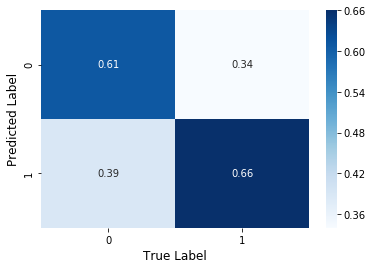

              precision    recall  f1-score   support

           0       0.64      0.61      0.63      7142
           1       0.63      0.66      0.64      7142

   micro avg       0.64      0.64      0.64     14284
   macro avg       0.64      0.64      0.64     14284
weighted avg       0.64      0.64      0.64     14284



In [26]:
report, cm = model_acc(lr_y_test_pred, y_test[:,0])
print(report)

In [27]:
len(lr_y_test_pred)

14284

# 3.5 Calculating Feature Importance for Linear Regr
<a id="3.5"> </a>

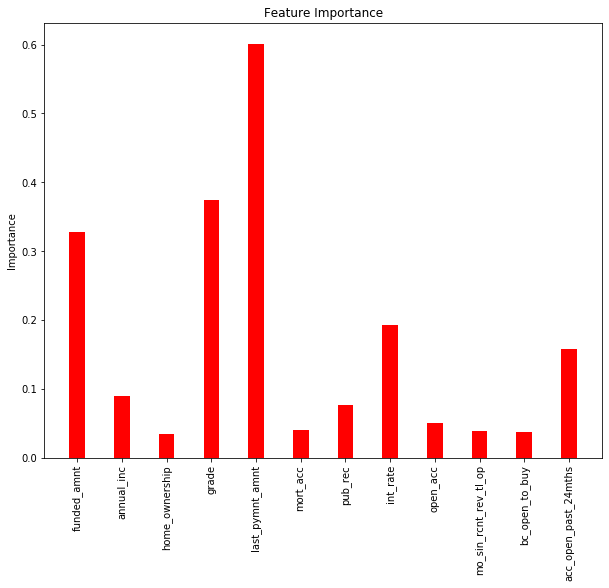

In [28]:
lr_feature_importance = abs(np.std(X_train, 0)*lr.coef_[0])
plot_feat_imp(lr_feature_importance, top_ranked_features)

# 3.6 Logistic Regression with Grid Search
<a id="3.6"> </a>

In [29]:
from sklearn.model_selection import GridSearchCV
def cross_validation_best_parameters(model, param_grid):
    grid = GridSearchCV(model, param_grid,cv=10, scoring='accuracy')
    grid.fit(X,y)
    mean_scores = grid.cv_results_['mean_test_score']
    return mean_scores,grid.best_score_,grid.best_estimator_
logreg = LogisticRegression(random_state=0)
c=[0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = dict(C=c)
mean_scores,Best_Accuracy, Best_classifier = cross_validation_best_parameters(logreg,param_grid)
print("Best accuracy is "+ str(Best_Accuracy))
print(Best_classifier)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_

Best accuracy is 0.6213962670997913
LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


# 4. Model 2: Random Forest

The random forest is a model made up of many decision trees. Rather than just simply averaging the prediction of trees (which we could call a “forest”), this model uses two key concepts that gives it the name random:
1. Random sampling of training data points when building trees
2. Random subsets of features considered when splitting nodes

![title](rand-forest-2.jpg)

<a id="4"> </a>

Sklear doc:
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

## 4.1 Find the best combinations of hyperparameters
<a id="4.1"> </a>
- Lets use the sklear tool: grid_serach

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
rf = RandomForestClassifier(criterion='gini', random_state=0)
maxFeatures = range(1,len(top_ranked_features))
param_dist = dict(max_features=maxFeatures)
rand = RandomizedSearchCV(rf, param_dist, cv=2, scoring='accuracy', n_iter=len(maxFeatures), random_state=10)
X=df[top_ranked_features].values
y=df[target].values
rand.fit(X,y[:,0])
mean_scores = rand.cv_results_['mean_test_score']
#print('Best Accuracy = '+str(rand.best_score_))
print(rand.best_estimator_)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: F

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)


In [31]:
print(rand.best_estimator_.max_features)

2


## 4.2 Build, Train and Predict
<a id="4.2"> </a>

In [32]:
from sklearn import metrics 
randomForest = RandomForestClassifier(bootstrap=True,criterion = "gini",
                                      max_features=rand.best_estimator_.max_features,random_state=0,
                                      class_weight="balanced")
randomForest.fit(X_train,y_train)
rfPredict = randomForest.predict(X_test)
rfPredictproba = randomForest.predict_proba(X_test)[:,1] #for ROC curve
roc_score = metrics.roc_auc_score(y_test,rfPredict)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


# 4.3 Evaluating RF Prediction Accuracy
<a id="4.3"> </a>

              precision    recall  f1-score   support

           0       0.62      0.67      0.64      7142
           1       0.64      0.60      0.62      7142

   micro avg       0.63      0.63      0.63     14284
   macro avg       0.63      0.63      0.63     14284
weighted avg       0.63      0.63      0.63     14284



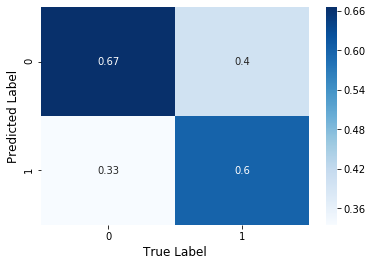

In [33]:
report, cm = model_acc(rfPredict, y_test[:,0])

In [34]:
X_test.shape

(14284, 12)

# 4.4 Plotting Feature importance for RF
<a id="4.4"> </a>

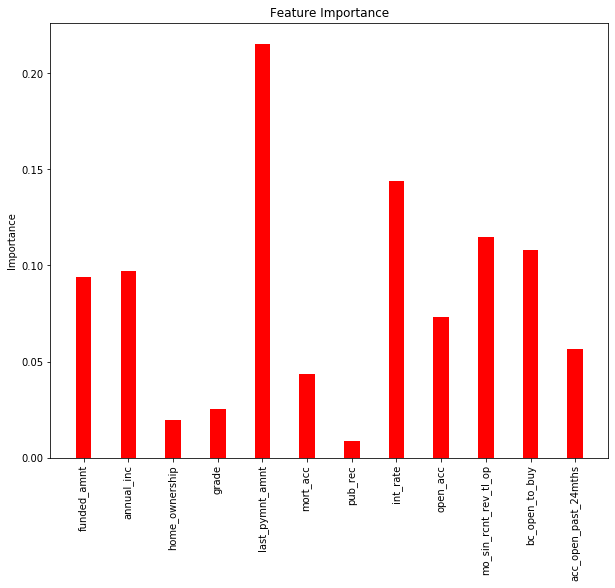

In [35]:
plot_feat_imp(randomForest.feature_importances_, top_ranked_features)

# 5. Model 3: Gradient Boosting
<a id="5"> </a>

You can use different versions of the algorithm:
- https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting
- https://lightgbm.readthedocs.io/en/latest/

# 5.1 Build, Train and Predict
<a id="5.1"> </a>

In [36]:
lgb=GradientBoostingClassifier(random_state=51, max_depth=7, n_estimators=100, learning_rate=1.0)
lgb.fit(X_train,y_train)
lgb_y_test_pred =lgb.predict(X_test)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# 5.2 Evaluating GB Prediction Accuracy
<a id="5.2"> </a>

              precision    recall  f1-score   support

           0       0.73      0.79      0.76      7142
           1       0.77      0.70      0.73      7142

   micro avg       0.74      0.74      0.74     14284
   macro avg       0.75      0.74      0.74     14284
weighted avg       0.75      0.74      0.74     14284



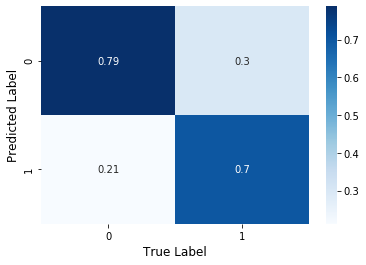

In [37]:
report, cm = model_acc(lgb_y_test_pred, y_test[:,0])

# 5.3 Calculating Feature Importance for GB
<a id="5.3"> </a>

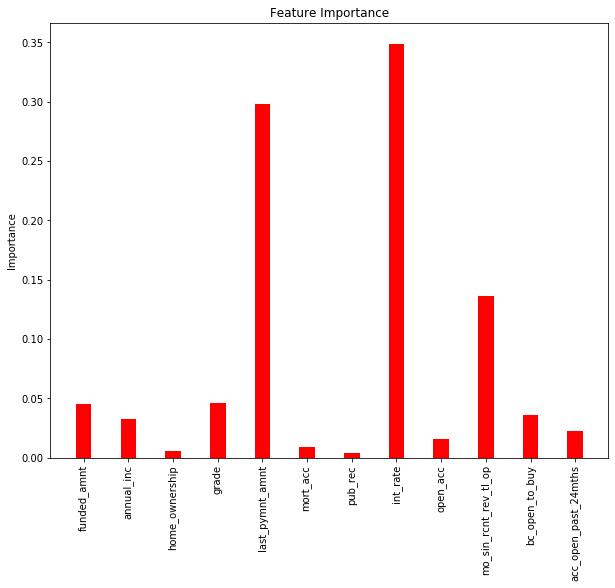

In [42]:
plot_feat_imp(lgb.feature_importances_, top_ranked_features)

# 6. Model 4: Naive Bayes

Essentially it allows us to determine posteries probabilities from out priors when presented with evidance.

## Baye's theorem:
Existing predictions can be revised given updated experince/evidence.

$P(A|E) = \frac{P(A,E)}{P(A)}$

How lickly is A than B now = how likely was A than B before new evidence TIMES how likely the evidence would be to occur if A were true than if B were true.

<a id="6"> </a>

In [43]:
from sklearn.naive_bayes import GaussianNB

# 6.1 Build, Train and Predict
<a id="6.1"> </a>

In [44]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
lgb_y_test_pred =gnb.predict(X_test)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# 6.2 Evaluating NB Prediction Accuracy
<a id="6.2"> </a>

              precision    recall  f1-score   support

           0       0.63      0.46      0.54      7142
           1       0.58      0.73      0.64      7142

   micro avg       0.60      0.60      0.60     14284
   macro avg       0.60      0.60      0.59     14284
weighted avg       0.60      0.60      0.59     14284



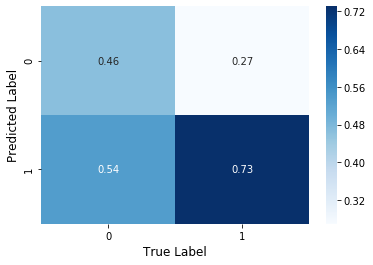

In [45]:
report, cm = model_acc(lgb_y_test_pred, y_test[:,0])